In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

## Creating Data

(1250,) (250,) (1250,) (250,)


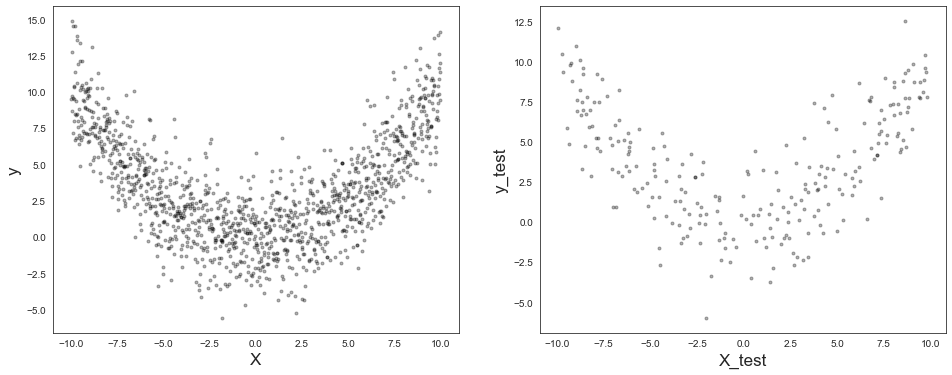

In [2]:
def load_quadratic_data(num=1500, scale=2, test_size=1/6, sort=True):
    X = np.linspace(-10, 10, num)
    y = 0.1*X**2 + np.random.normal(size=num, scale=scale)
    
    # splitting according to train-test split
    X, X_test, y, y_test = train_test_split(X, y, test_size=test_size)
    
    if sort:
        inds_x, inds_test = np.argsort(X), np.argsort(X_test)
        X, y = X[inds_x], y[inds_x]
        X_test, y_test = X_test[inds_test], y_test[inds_test]
    
    return X, X_test, y, y_test

X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

## Polynomial Regression Model

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

In [3]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1102.27draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.102174,0.000931,0.000029,0.100410,0.104038,921.217855,1.000614
b,0.000379,0.005078,0.000119,-0.009604,0.010279,1589.983905,0.999552
c,-0.060503,0.042378,0.001241,-0.145972,0.016046,1006.258304,1.000503


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    return (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise

In [5]:
class CalibratedRegression:
    
    def __init__(self, X, y, model, cal_prop=0.2, cdf_method='bayesian', pp=None, pp_params=None):
        '''Initializes the class'''
        # data
        self.X = X
        self.y = y
        
        # model
        self.model = model
        self.posterior_predictive = pp
        self.pp_params = pp_params
        
        # calibration features
        self.calibration_dataset = None
        self.isotonic = None
        
        # split up training and calibration sets
        self.X_train, self.X_cal, self.y_train, self.y_cal = train_test_split(X, y, test_size=cal_prop)
        
        if cdf_method in ['bayesian','bootstrap','statsmodels']:
            self.cdf_method = cdf_method
        else:
            raise ValueError("cdf_method must be of type 'bayesian', 'bootstrap', or 'statsmodels'")
    
    def bootstrap():
        '''Utility function to bootstrap.'''
        pass
    
    def fit(self):
        '''Fit underlying model'''
        
        if self.cdf_method == 'bayesian':
            # there should be a posterior_predictive function
            assert self.posterior_predictive is not None and self.pp_params is not None
            # call the posterior predictive function
            self.posterior_predictive_cal = self.posterior_predictive(self.X_cal, **pp_params)
            
        elif self.cdf_method == 'bootstrap':
            # get CDF from bootstrapping
            pass
        
        elif self.cdf_method == 'statsmodels':
            # get CDF from statsmodels 
            pass
        
        # create the calibration dataset
        self.calibration_dataset, self.predicted_cdf, self.empirical_cdf = self.create_calibration_dataset()
            
        # fit the isotonic regression
        self.isotonic = IsotonicRegression(out_of_bounds='clip')
        self.isotonic.fit(self.empirical_cdf, self.predicted_cdf)
            
        return self
        
    def create_calibration_dataset(self, X=None, y=None, pp=None, pp_params=None):
        '''Creates a Pandas dataframe which has the calibration dataset''' 
        # check conditions
        X = X if X is not None else self.X_cal
        y = y if y is not None else self.y_cal
        pp = pp if pp is not None else self.posterior_predictive
        pp_params = pp_params if pp_params is not None else self.pp_params
        
        post_pred = pp(X, **pp_params)
        predicted_cdf = self.pcdf(post_pred, y) # predicted CDF
        empirical_cdf = self.ecdf(predicted_cdf) # empirical CDF
        
        # putting results in a Pandas dataframe
        calibration_dataset = pd.DataFrame({'X': X, 'y': y, 
                                            'predicted_cdf': predicted_cdf, 
                                            'empirical_cdf': empirical_cdf})
        
        return calibration_dataset[['X','y','predicted_cdf','empirical_cdf']], predicted_cdf, empirical_cdf
    
    def predict(self, X_test, y_pred, quantiles):
        '''Return point estimates and PIs.'''
        assert self.isotonic is not None, 'Call fit() first'
        new_quantiles = self.predict_quantiles(quantiles)
        
        # saving variables
        self.X_test = X_test
        self.y_pred = y_pred
        self.posterior_predictive_test = self.posterior_predictive(X_test, **self.pp_params)
        
        # returning quantiles
        return self.posterior_predictive_test, new_quantiles
    
    def predict_quantiles(self, quantiles):
        '''Returns transformed quantiles according to the isotonic regression model'''
        assert self.isotonic is not None, 'Call fit() first'
        return self.isotonic.transform(quantiles)
    
    def pcdf(self, post_pred, y):
        '''Gets Predicted CDF'''
        return np.mean(post_pred <= y.reshape(-1,1), axis=1)
        
    def ecdf(self, predicted_cdf):
        '''Empirical CDF.'''
        empirical_cdf = np.zeros(len(predicted_cdf))
        for i, p in enumerate(predicted_cdf):
            empirical_cdf[i] = np.sum(predicted_cdf <= p)/len(predicted_cdf)
        return empirical_cdf
    
    def plot_calibration_curve(self, ax):
        '''Plot calibration curve as described in paper (figure 3b).'''
        assert self.empirical_cdf is not None, 'Call fit() first'
        ax.scatter(self.predicted_cdf, self.empirical_cdf, alpha=0.7)
        ax.plot([0,1],[0,1],'--', color='grey')
        ax.set_xlabel('Predicted', fontsize=17)
        ax.set_ylabel('Empirical', fontsize=17)
        ax.set_title('Predicted CDF vs Empirical CDF')
        return ax
    
    def plot_diagnostic_curve(self, ax, intervals):
        '''Plot diagnostic curve as described in paper (figure 3c).'''
        assert self.posterior_predictive_test.shape, 'Call predict() first'
        
        # uncalibrated
        observed_uncalibrated = np.mean(self.predicted_cdf.reshape(1, -1) <= intervals, axis=1) 
        ax.plot(intervals, observed_uncalibrated, 'o-', color='purple', label='uncalibrated')
        
        # calibrated
        predicted_values = self.pcdf(self.posterior_predictive_test, self.y_pred)
        calibrated_values = self.isotonic.predict(predicted_values)
        observed_calibrated = np.mean(calibrated_values.reshape(1, -1) <= intervals, axis=1) 
        ax.plot(intervals, observed_calibrated, 'o-', color='red', label='calibrated')
        
        # default line
        ax.plot([0,1],[0,1], '--', color='black', alpha=0.7)
        ax.set_ylabel('Observed Confidence Level', fontsize=17)
        ax.set_xlabel('Expected Confidence Level', fontsize=17)
        ax.legend(fontsize=17)
        return ax

,X,y,predicted_cdf,empirical_cdf
0,-4.569713,2.322899,0.595,0.540
1,6.130754,3.169633,0.263,0.392
2,7.651768,6.880908,0.808,0.684
3,4.102735,2.821146,0.864,0.720
4,9.319546,7.985396,0.183,0.352


[0.         0.515      0.99910714]


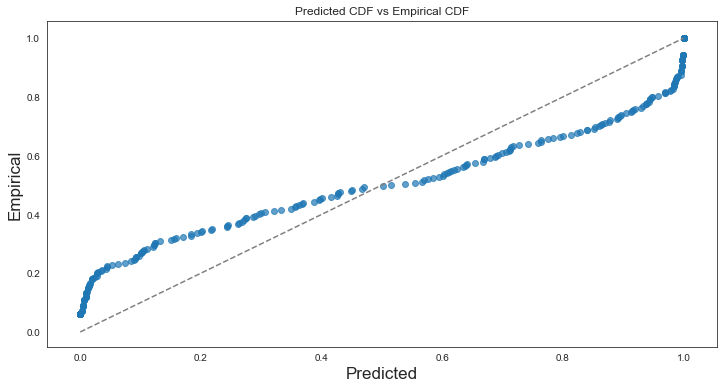

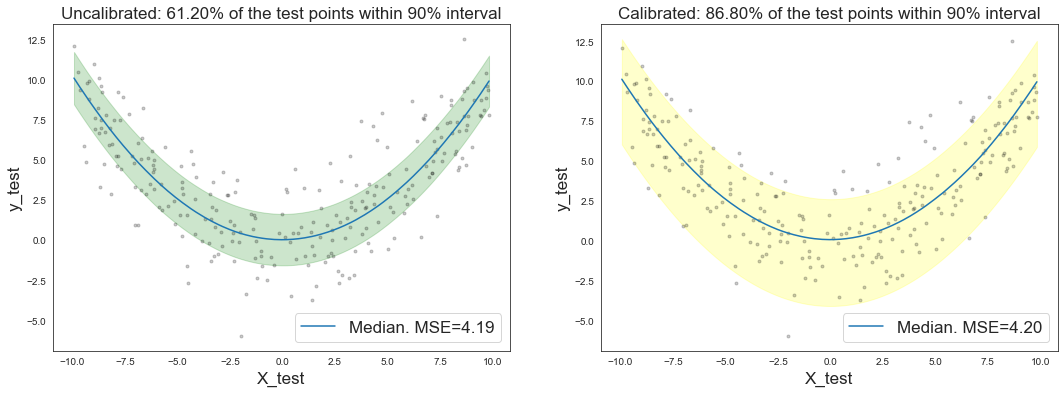

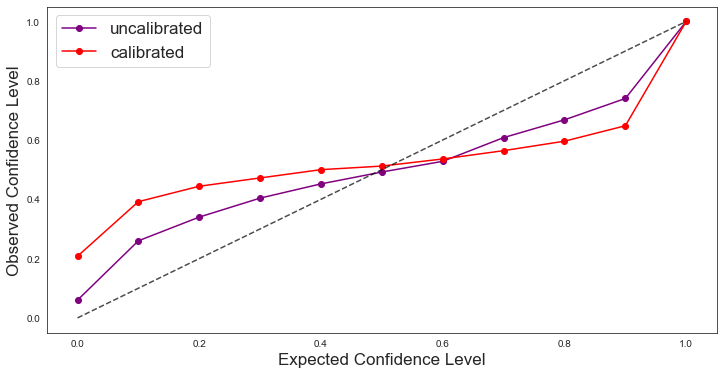

In [6]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax)

# prediction
post_pred_test, new_quantiles = calib.predict(X_test, y_test, quants)
cal_lower, cal_median, cal_upper = np.quantile(post_pred_test, new_quantiles, axis=1)
unc_lower, unc_median, unc_upper = np.quantile(post_pred_test, quants, axis=1)
perc_within_unc = np.mean((y_test <= unc_upper)&(y_test >= unc_lower))
perc_within_cal = np.mean((y_test <= cal_upper)&(y_test >= cal_lower))

# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].plot(X_test, y_test, 'o', color='black', alpha=0.2, markersize=3)
ax[0].set_title(f'Uncalibrated: {100*perc_within_unc:.2f}% of the test points within 90% interval', fontsize=17)
ax[0].set_xlabel('X_test', fontsize=17)
ax[0].set_ylabel('y_test', fontsize=17)
ax[0].fill_between(X_test, unc_lower, unc_upper, color='green', alpha=0.2)
ax[0].plot(X_test, unc_median, label=f'Median. MSE={mean_squared_error(y_test, unc_median):.2f}')
ax[0].legend(fontsize=17)

ax[1].plot(X_test, y_test, 'o', color='black', alpha=0.2, markersize=3)
ax[1].set_title(f'Calibrated: {100*perc_within_cal:.2f}% of the test points within 90% interval', fontsize=17)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17)
ax[1].fill_between(X_test, cal_lower, cal_upper, color='yellow', alpha=0.2)
ax[1].plot(X_test, cal_median, label=f'Median. MSE={mean_squared_error(y_test, cal_median):.2f}')
ax[1].legend(fontsize=17)

# diagnostic plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_diagnostic_curve(ax, intervals=np.linspace(0,1,11).reshape(-1,1));

---